In [1]:
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

dvc = torch.device("cuda" if torch.cuda.is_available() else "cpu")

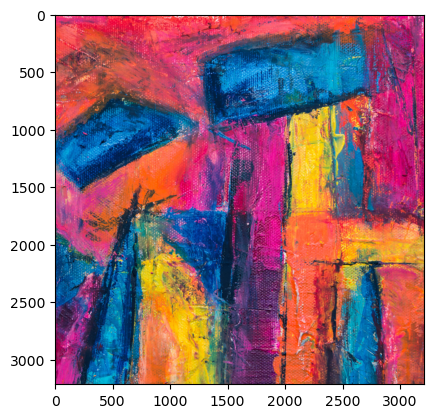

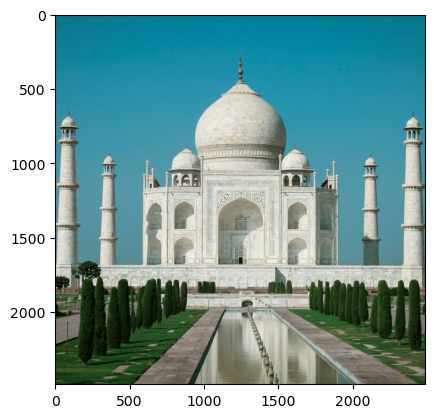

In [2]:
def image_to_tensor(image_filepath, image_dimension=128): # input: image 파일 경로, image 최대 크기(기본값 128)
    img = Image.open(image_filepath).convert('RGB') # image를 열어 RGB 모드로 변환
    
    # image 출력 
    plt.figure()
    plt.imshow(img)
    
    if max(img.size) <= image_dimension: # img.size (width, height) 튜플 반환
        # 가로 세로 중 더 큰 값은 img_size에 할당 
        # -> 해당 값이 image_dimension보다 작거나 같으면 원본 크기를 그대로 사용
        img_size = max(img.size) 
    else:
        img_size = image_dimension

    # TorchVision preprocessing pipline
    torch_transformation = torchvision.transforms.Compose([
        torchvision.transforms.Resize(img_size), # image resize
        torchvision.transforms.ToTensor() # tensor 변환
    ])

    # tensor의 0번째 차원에 새로운 차원 추가 -> [배치 크기, 채널, 높이, 너비]
    img = torch_transformation(img).unsqueeze(0)

    # tensor를 dvc로 옮기고 data type을 torch.float로 변환  
    return img.to(dvc, torch.float)

style_image = image_to_tensor(r"C:\Users\degas\Desktop\style.jpg")
content_image = image_to_tensor(r"C:\Users\degas\Desktop\content.jpg")

In [3]:
# gram_matrix
def gram_matrix(ip): # input: iamge feature map tensor -> gram matrix 계산
    num_batch, num_channels, height, width = ip.size() # 배치크기, 채널수, 높이, 너비 반환
    
    # reshape, tensor 형태 변경
    # 배치 크기와 채널 수를 하나의 차원으로 합치기 num_batch * num_channels
    # 높이와 너비를 하나의 차원으로 합치기 width * height
    # 결과적으로 2차원 텐서 생성
    feats = ip.view(num_batch * num_channels, width * height) # reshape
    
    gram_mat = torch.mm(feats, feats.t()) # 행렬곱셈 수행(내적 수행)

    # Gram matrix의 값을 전체 원소의 개수로 나누어 정규화
    # Gram matrix 값들이 스케일에 영향을 덜 받게 되어, 모델 학습 시 안정성 강화
    return gram_mat.div(num_batch * num_channels * width * height) # 최종적으로 정규화된 Gram matrix 반환

In [4]:
# pretrained model
vgg19_model = torchvision.models.vgg19(pretrained=True).to(dvc)
print(vgg19_model)
# input channel / output channel / kernel size / stride / padding

C:\Users\degas\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\degas\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [5]:
vgg19_model = vgg19_model.features # convolution과 pooling으로 구성된 특징 추출 부분.

for param in vgg19_model.parameters(): 
    param.requires_grad_(False) # parameter에 대해 역전파 gradient 계산 X, 모델 학습 중 업데이트 X 설정

In [6]:
# change maxpool layers to avgpool

conv_indices = []

for i in range(len(vgg19_model)):
    # 해당 layer 동일한 kernel_size, stride, padding 값을 가지는 AvgPool2d layer로 교체
    # why? average pooling이 더 부드러운 특징 추출에 용이
    if vgg19_model[i]._get_name() == 'MaxPool2d':
        vgg19_model[i] = nn.AvgPool2d(kernel_size=vgg19_model[i].kernel_size, 
                                      stride=vgg19_model[i].stride, 
                                      padding=vgg19_model[i].padding)
    if vgg19_model[i]._get_name() == 'Conv2d':
        conv_indices.append(i)
        
conv_indices = dict(enumerate(conv_indices, 1))
print(vgg19_model)
# MaxPool2d layer가 AvgPool2d로 교체된 모델 구조와, 
# 기존의 Conv2d layer들이 유지된 상태 확인

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (19): Conv2d(256

In [7]:
# clip until the last relevant layer
layers = {1: 's', 2: 's', 3: 's', 4: 'sc', 5: 's'}

# style transfer에 사용할 VGG-19 모델의 일부 선택
vgg_layers = nn.ModuleList(vgg19_model)

last_layer_idx = conv_indices[max(layers.keys())]
vgg_layers_trimmed = vgg_layers[:last_layer_idx+1]

neural_style_transfer_model = nn.Sequential(*vgg_layers_trimmed)
print(neural_style_transfer_model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


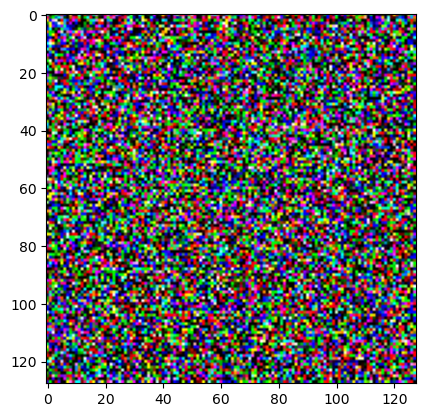

In [8]:
# initialize as the content image
# ip_image = content_image.clone()
# initialize as random noise:
ip_image = torch.randn(content_image.data.size(), device=dvc) # input image initialize

# random noise tensor 생성 -> visualization
plt.figure()
plt.imshow(ip_image.squeeze(0).cpu().detach().numpy().transpose(1,2,0).clip(0,1));

epoch number 50
style loss = 2.566176176071167, content loss = 4.865628242492676


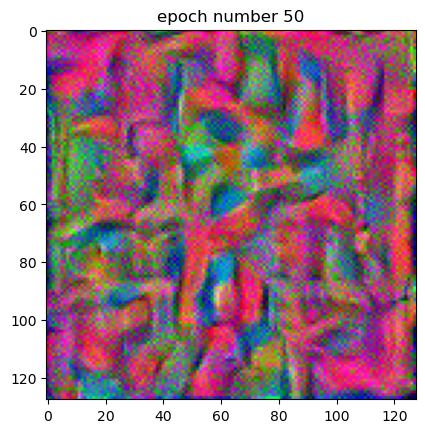

epoch number 100
style loss = 1.1735272407531738, content loss = 3.2984507083892822


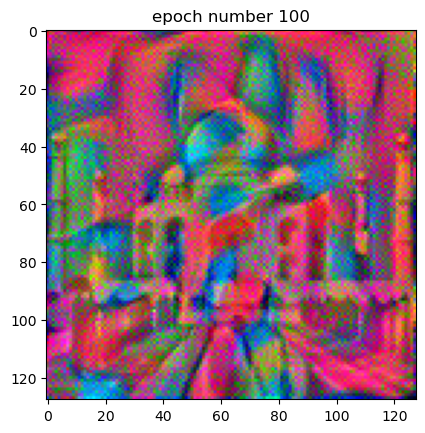

epoch number 150
style loss = 0.7615841031074524, content loss = 2.854830265045166


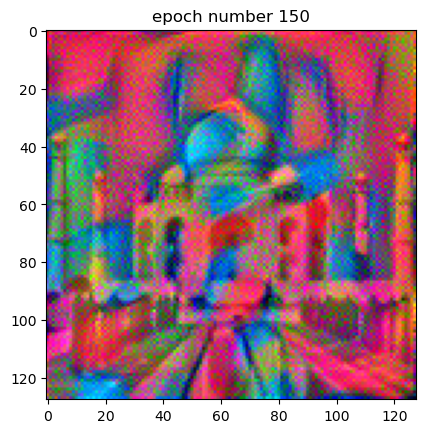

epoch number 200
style loss = 0.5853421092033386, content loss = 2.6280136108398438


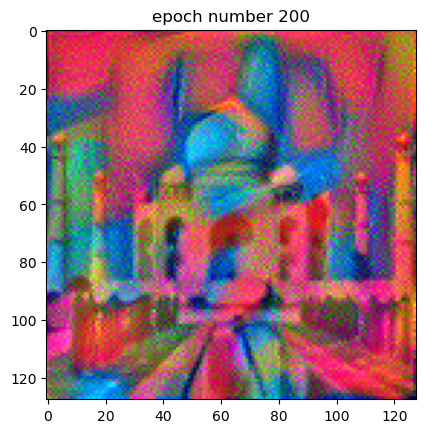

epoch number 250
style loss = 0.49491825699806213, content loss = 2.4866890907287598


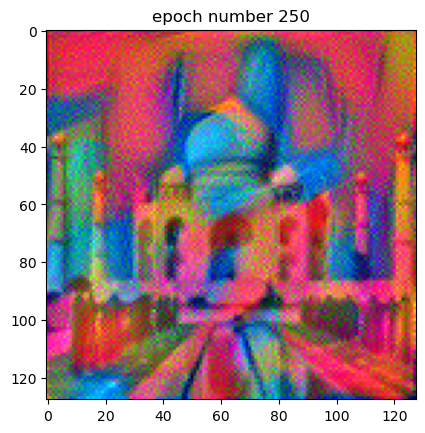

epoch number 300
style loss = 0.442781925201416, content loss = 2.3914577960968018


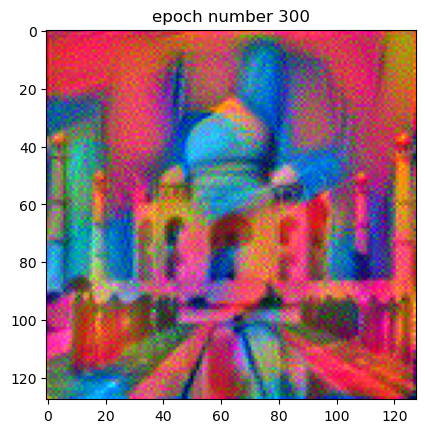

In [9]:
num_epochs = 300
wt_style = 1e6 # style loss에 곱해줄 가중치
wt_content = 1 # content loss에 곱해줄 가중치
style_losses = []
content_losses = []
opt = optim.Adam([ip_image.requires_grad_()], lr=0.1) # optimizer Adam 사용

for curr_epoch in range(1, num_epochs+1):
    
    ip_image.data.clamp_(0, 1) # image pixel value 0~1
    opt.zero_grad() # 누적 gradient initialize
    epoch_style_loss = 0 
    epoch_content_loss = 0

    # 각 key는 convolutuion style transfer에 사용할 특정 convolutuion layer 지정
    # 이때 해당 layer에 대해 style('s') or content('c') loss을 계산
    for k in layers.keys():
        if 'c' in layers[k]:
            # 그래프 분리를 통한 content image의 가중치가 업데이트 x 
            target = neural_style_transfer_model[:conv_indices[k]+1](content_image).detach()
            # 생성 image도 같은 layer까지 전달하여 특징 추출
            ip = neural_style_transfer_model[:conv_indices[k]+1](ip_image) 
            # 두 image의 feature map 간의 MSE 계산 -> content loss 누적
            epoch_content_loss += torch.nn.functional.mse_loss(ip, target)
        if 's' in layers[k]:
            # style image를 지정된 layer까지 통과시켜 feature map 획득 후, gram matrix 계산 
            target = gram_matrix(neural_style_transfer_model[:conv_indices[k]+1](style_image)).detach()
            # 생성 image도 같은 layer까지 전달하여 특징 추출
            ip = gram_matrix(neural_style_transfer_model[:conv_indices[k]+1](ip_image))
            # 두 image의 feature map 간의 MSE 계산 -> style loss 누적
            epoch_style_loss += torch.nn.functional.mse_loss(ip, target)

    # loss weight 적용 및 total loss 계산
    epoch_style_loss *= wt_style
    epoch_content_loss *= wt_content
    total_loss = epoch_style_loss + epoch_content_loss
    total_loss.backward() 

    # 중간 결과 출력 (50 epoch마다)
    if curr_epoch % 50 == 0:
        print(f"epoch number {curr_epoch}")
        print(f"style loss = {epoch_style_loss}, content loss = {epoch_content_loss}")
        plt.figure()
        plt.title(f"epoch number {curr_epoch}")
        plt.imshow(ip_image.data.clamp_(0, 1).squeeze(0).cpu().detach().numpy().transpose(1,2,0))
        plt.show()
        style_losses += [epoch_style_loss]
        content_losses += [epoch_content_loss]

    opt.step() # optimizer update